In [1]:
COLS_EXCLUDE = ['Median Sale Price','Region','neighborhood',
                'location','city','property_type','state',
                'Month of Period End', 'Median_Sale_Price_Bin', 'neighborhood_num',
                'Month of Period End', 'Unamed: 0', 'Median Sale Price MoM', 'Median Sale Price YoY']

DATA = 'san_jose_property.csv'

In [2]:
import csv
import itertools
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path

from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.metrics import confusion_matrix
from string import punctuation

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.around(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def make_histogram(data, bins):
    fig, ax = plt.subplots()

    # histogram our data with numpy
    n, bins = np.histogram(data, bins)

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n


    # we need a (numrects x numsides x 2) numpy array for the path helper
    # function to build a compound path
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    # get the Path object
    barpath = path.Path.make_compound_path_from_polys(XY)

    # make a patch out of it
    patch = patches.PathPatch(barpath)
    ax.add_patch(patch)

    # update the view limits
    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

    plt.show()

In [32]:
def plot_accuracy(performance, estimators, title='', xlabel='', ylabel=''):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(estimators, performance)
    plt.show();

In [5]:
# x_train has 70% of the dataset
# x_test has 30% of the dataset
# ignore y_train and y_test
# Regression: Train on x_train, remove non-numerical columns first!
# Test on x_test

# splits dataset up into training (70%) and testing (30%) sets
# evenly based on neighborhood

def split_test_train(total, stratify_col):
    total2 = total.copy(deep=True)
    y = total2[stratify_col]
    x = total2
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
    return (x_train, x_test, y_train, y_test)

In [6]:
# fits a regression model to a training set
def model(x_train, model, label, cols_exclude=COLS_EXCLUDE):
    X = x_train.loc[:, x_train.columns.difference(cols_exclude)]
    Y = x_train.loc[:, label]
    model.fit(X, Y)
    return (model)

In [7]:
def predict(x_test, model, label):
    X_test = x_test.loc[:, x_train.columns.difference(COLS_EXCLUDE)]
    Y_test = x_test.loc[:, label]
    return (model.predict(X_test), Y_test)

In [8]:
# how many of the predicted prices were within
# thresh % of the actual price?
# return a ratio

def evaluate(y_pred, y_test, thresh):
    assert len(y_pred) == len(y_test)
    result = []
    for (pred, test) in zip(y_pred, y_test):
        result.append(math.fabs((test-pred)/test) <= thresh)
    
    return (float(sum(result))/float(len(result)))

In [9]:
# encode catgorial variable so that it can be used
# in regression
def encode_categorial(df):
    neighborhoods = df.neighborhood.unique()
    for n in neighborhoods:
        df[n] = [1 if x == n else 0 for x in df.neighborhood]
    return (df)

In [10]:
total = pd.read_csv(DATA)
lin_reg_df = encode_categorial(total.copy())
x_train, x_test, _, _ = split_test_train(lin_reg_df, 'Median Sale Price')

### Linear Regression Model (least squares method) implementation and slope coefficients

In [11]:
reg = model(x_train, linear_model.LinearRegression(), 'Median Sale Price')

np.set_printoptions(precision=3, suppress=True)
cols = x_train.loc[:, x_train.columns.difference(COLS_EXCLUDE)].columns[:19]
coeff = np.array(reg.coef_)[:19]

for (col, coeff) in zip(cols, coeff):
    print (col,coeff)

('Average Sale To List', 7988.7533416185779)
('Average Sale To List MoM', -2015.0963963103397)
('Average Sale To List YoY', -4028.6151490451875)
('Days on Market', 4.6945733122680622)
('Days on Market MoM', -90.70941822544728)
('Days on Market YoY', 217.14372464818996)
('Homes Sold', 12.24425698748064)
('Homes Sold MoM', -12.121592915115343)
('Homes Sold YoY', 15.343942931973061)
('Inventory', -3.4997397983104293)
('Inventory MoM', -11.206981507612113)
('Inventory YoY', 50.478437831250062)
('Month', 2997.0680171896597)
('New Listings', 3.4386957276435623)
('New Listings MoM', -17.422600233224671)
('New Listings YoY', 77.030978836904637)
('Unnamed: 0', -11.518845147741104)
('Year', 74.189348134499824)
('alexander', -20097241455309.043)


In [12]:
lin_reg_df.head()

,Unnamed: 0,Region,Month of Period End,Median Sale Price,Median Sale Price MoM,Median Sale Price YoY,Homes Sold,Homes Sold MoM,Homes Sold YoY,New Listings,...,summerside,tamien,the,townsend,vinci,west,westmont,whaley,willow,winchester
0,41,"San Jose, CA - Alexander",June 2015,352000,6.3,30.6,3,-25.0,-25.0,9.0,...,0,0,0,0,0,0,0,0,0,0
1,45,"San Jose, CA - Alexander",October 2015,335000,7.0,35.6,8,-27.3,33.3,10.0,...,0,0,0,0,0,0,0,0,0,0
2,47,"San Jose, CA - Alexander",December 2015,345000,16.7,20.0,12,100.0,100.0,12.0,...,0,0,0,0,0,0,0,0,0,0
3,48,"San Jose, CA - Alexander",January 2016,338000,-2.2,25.0,14,16.7,180.0,9.0,...,0,0,0,0,0,0,0,0,0,0
4,49,"San Jose, CA - Alexander",February 2016,365000,8.1,29.2,13,-7.1,116.7,6.0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
Y_pred, Y_test = predict(x_test, reg, 'Median Sale Price')

In [14]:
for t in [0.05, 0.10, 0.15, 0.25]:
    print (evaluate(Y_pred, Y_test, t))

0.215517241379
0.41976127321
0.604442970822
0.832559681698


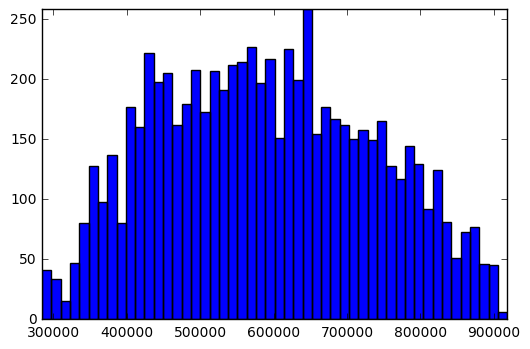

In [15]:
make_histogram(x_train['Median Sale Price'], 50)

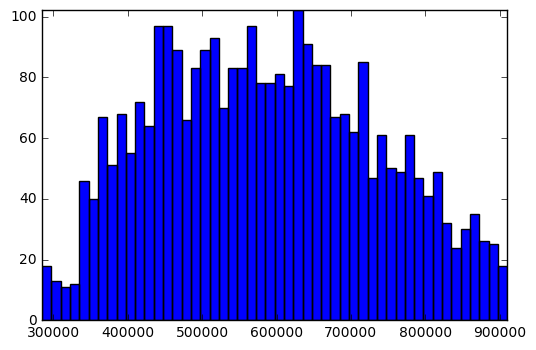

In [16]:
make_histogram(x_test['Median Sale Price'], 50)

### Least Squares Regression

In [39]:
least_squares_reg = model(x_train, linear_model.LinearRegression(), 'Median Sale Price')
Y_pred, Y_test = predict(x_test, least_squares_reg, 'Median Sale Price')
print (evaluate(Y_pred, Y_test, 0.1)*100)

41.976127321


### Ridge Regression - penalizes for size of coefficients

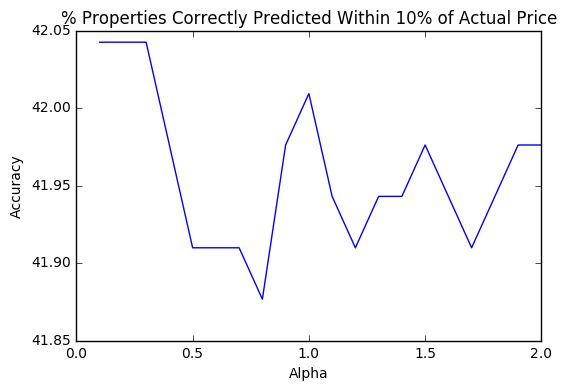

In [40]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
perf= []

for a in alphas:
    ridge_reg = model(x_train, linear_model.Ridge(alpha=a), 'Median Sale Price')
    Y_pred, Y_test = predict(x_test, ridge_reg, 'Median Sale Price')
    perf.append(evaluate(Y_pred, Y_test, 0.1)*100)
    
plot_accuracy(perf, alphas, title='% Properties Correctly Predicted Within 10% of Actual Price',
             xlabel='Alpha', ylabel='Accuracy')

In [48]:
ridge_reg = model(x_train, linear_model.Ridge(alpha=0.1), 'Median Sale Price')
Y_pred, Y_test = predict(x_test, ridge_reg, 'Median Sale Price')
print(evaluate(Y_pred, Y_test, 0.1)*100)

42.0424403183


### Bayesian Regression - Similar to ridge, can adapt to data better, and includes a regularization parameter

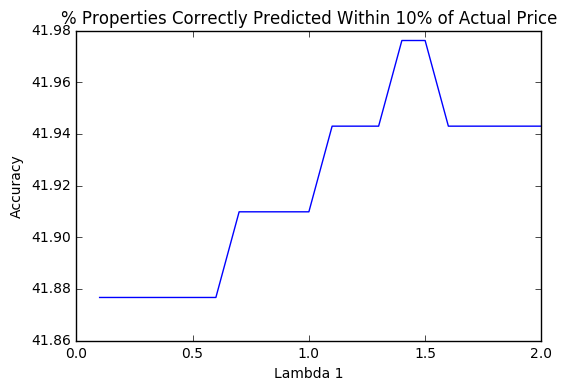

In [46]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
perf= []

for a in alphas:
    bay_reg = model(x_train, linear_model.BayesianRidge(lambda_1=a), 'Median Sale Price')
    Y_pred, Y_test = predict(x_test, bay_reg, 'Median Sale Price')
    perf.append(evaluate(Y_pred, Y_test, 0.1)*100)
    
plot_accuracy(perf, alphas, title='% Properties Correctly Predicted Within 10% of Actual Price',
             xlabel='Lambda 1', ylabel='Accuracy')

In [47]:
bay_reg = model(x_train, linear_model.BayesianRidge(lambda_1=1.5), 'Median Sale Price')
Y_pred, Y_test = predict(x_test, bay_reg, 'Median Sale Price')
print(evaluate(Y_pred, Y_test, 0.1)*100)

41.976127321


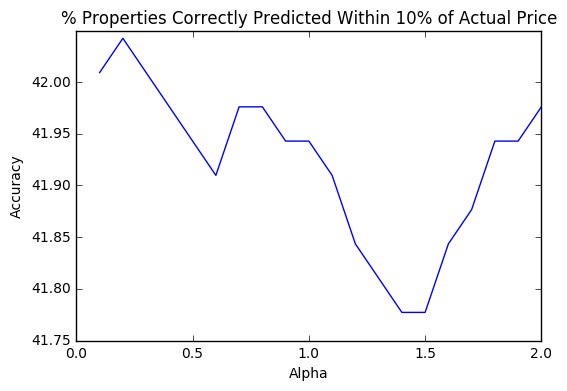

In [49]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
perf= []

for a in alphas:
    lasso_reg = model(x_train, linear_model.LassoLars(alpha=a), 'Median Sale Price')
    Y_pred, Y_test = predict(x_test, lasso_reg, 'Median Sale Price')
    perf.append(evaluate(Y_pred, Y_test, 0.1)*100)
    
plot_accuracy(perf, alphas, title='% Properties Correctly Predicted Within 10% of Actual Price',
             xlabel='Alpha', ylabel='Accuracy')

In [51]:
lasso_reg = model(x_train, linear_model.LassoLars(alpha=0.1), 'Median Sale Price')
Y_pred, Y_test = predict(x_test, lasso_reg, 'Median Sale Price')
print(evaluate(Y_pred, Y_test, 0.1)*100)

42.0092838196
